FMML Lab 18

The lab will cover the following topics

1) Introduction to time series

2) Classical Models like AR, MA, ARMA, and ARIMA, their comparisons

3) Many to One Sentiment Analysis using RNNs

Time Series Analysis

Time series represents a sequence of observations often ordered time based. In time series analysis, analysts record data points at consistent intervals over a set period of time rather than just recording the data points intermittently or randomly. Applications include in the domains of meteorology, finance and marketing. Time series analysis helps organizations understand the underlying causes of trends or systemic patterns over time.

Time series prediction task involves using past datapoints to predict the present or future data point(s).

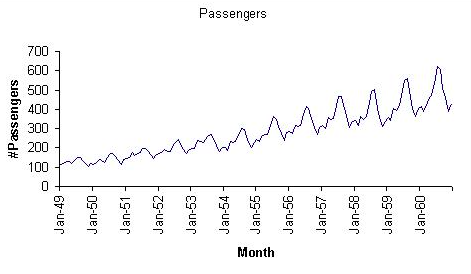

Autoregressive Process

Auto regressive process of order p is given by the formula 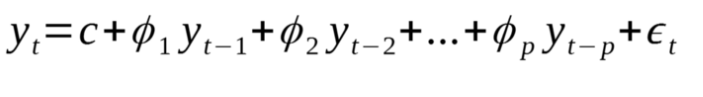

In [4]:
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.regression.linear_model import yule_walker

In [5]:
## Lets simulate the ArmaProcess of order 2 considering coefficients as given below.
ar2 = np.array([1, 0.33, 0.5])
ma = np.array([1])
simulated_AR2_data = ArmaProcess(ar2, ma).generate_sample(nsample=10000)


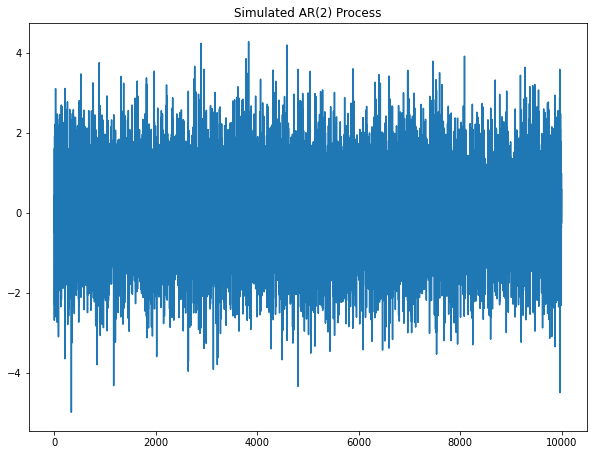

In [6]:
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(simulated_AR2_data)
plt.title("Simulated AR(2) Process")
plt.show()


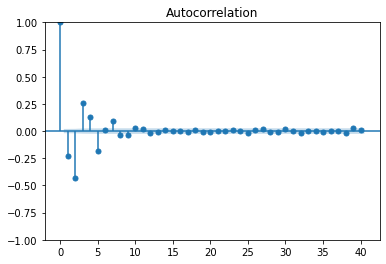

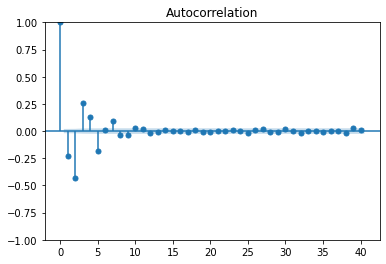

In [7]:
plot_acf(simulated_AR2_data)

The coefficient is slowly decaying. This means that it is unlikely a moving average process and it suggests that the time series can probably modelled with an autoregressive model.

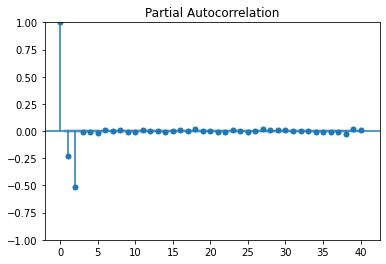

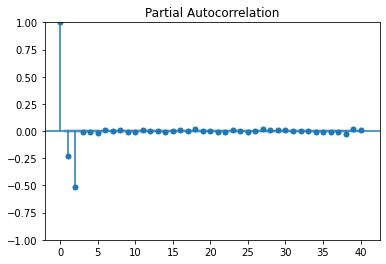

In [8]:
plot_pacf(simulated_AR2_data)

The coefficients are not significant after lag 2. Therefore, the partial autocorrelation plot is useful to determine the order of an AR(p) process. We will use Yule-Walker equation to solve for coefficients



In [9]:
rho, sigma = yule_walker(simulated_AR2_data, 2, method='mle')
print(f'rho: {-rho}')
print(f'sigma: {sigma}')

rho: [0.34247603 0.51007848]
sigma: 0.9994575903007143


The value of coefficients are almost same.

In [10]:
# Autoregressive models are applied to stationary time series only
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(simulated_AR2_data)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# The first value <0 and p should <= 0.05. Hence, our simulated time series is stationary.

ADF Statistic: -137.5063005828931
p-value: 0.0


Moving Average Method

The observation depends on the noise from previous observations.
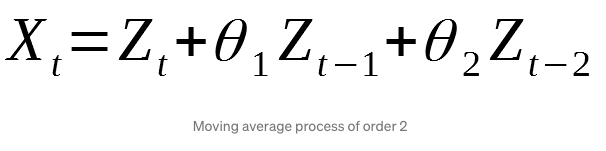

In [11]:
## Lets simulate a MA process of order 2
ar2 = np.array([2])
ma2 = np.array([1, 0.9, 0.3])
MA2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)


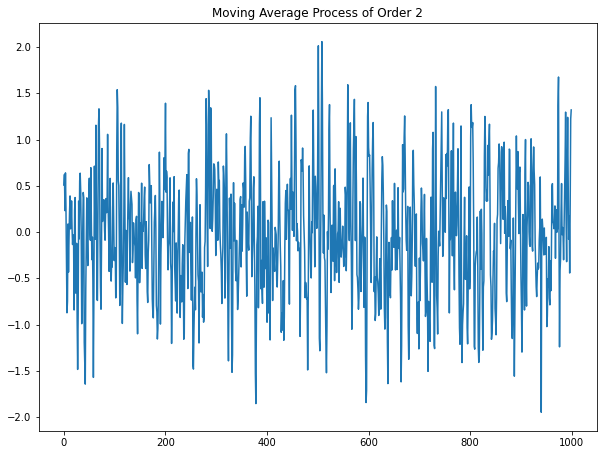

In [12]:
plt.figure(figsize=[10, 7.5]); # Set dimensions for figure
plt.plot(MA2_process)
plt.title('Moving Average Process of Order 2')
plt.show()


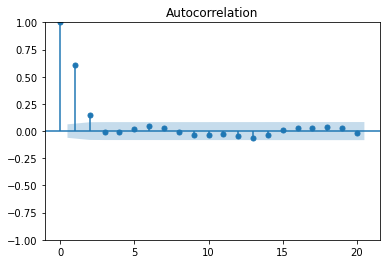

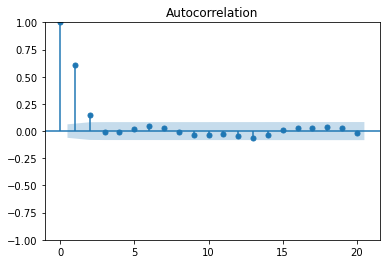

In [13]:
plot_acf(MA2_process, lags=20)


From the graph, the correlation is significant up to lag 2. Afterwards, the correlation is not significant anymore.


Let's look at ARMA process which involves both AR and MA.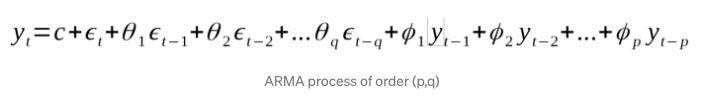

p: the order of the autoregressive process

q: the order of the moving average process

c: constant

epsilon: noise

In [14]:
## Task-1 Using the above code simulate the ARMA process with coefficients of your choice.
## Comment on autocorrelation and partial auto correlation graphs.

ARIMA

ARIMA stands for AutoRegressive Integrated Moving Average.

This model is the combination of autoregression, a moving average model and differencing. In this context, integration is the opposite of differencing.

p: the order of the autoregressive process

d: the degree of differencing (number of times it was differenced)

q: the order of the moving average process

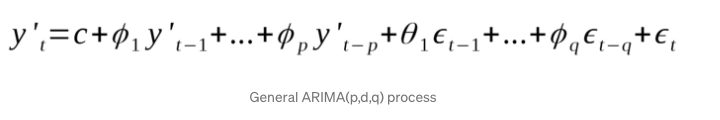

In [15]:
from google.colab import files
uploaded = files.upload()


ModuleNotFoundError: No module named 'google.colab'

In [16]:
import pandas as pd

In [17]:
data = pd.read_csv('./data/jj.csv')
data.head()


,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


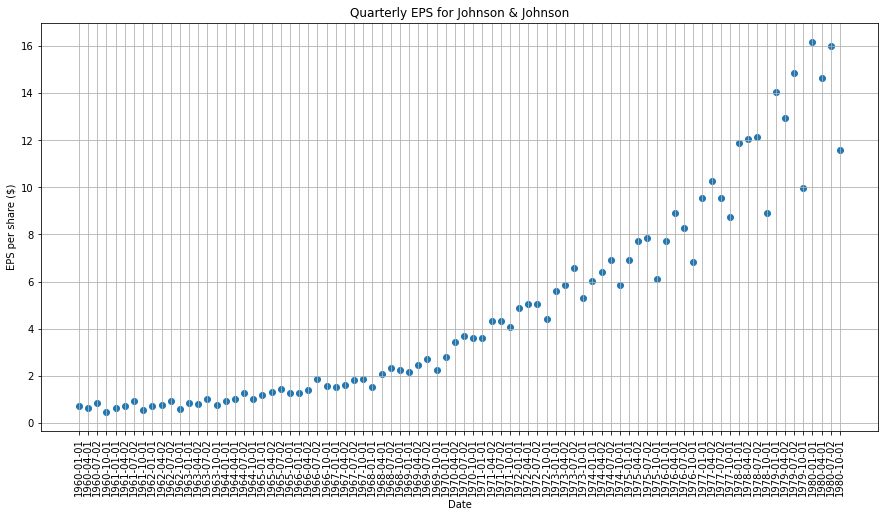

In [18]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.scatter(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


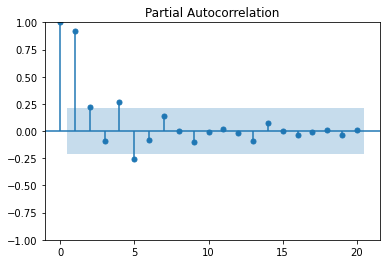

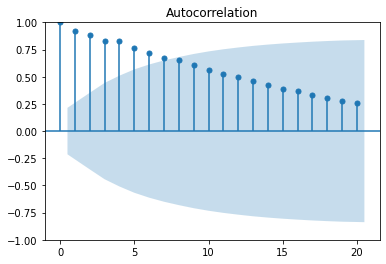

In [19]:
plot_pacf(data['data']);
plot_acf(data['data']);
## As you can see, there is no way of determining the right order for the AR(p) process or MA(q) process.

In [20]:
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

## The data is not stationary.

ADF Statistic: 2.7420165734574744
p-value: 1.0


In [21]:
# Take the log difference to make data stationary
data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])
data.head()


,date,data
1,1960-04-01,-0.119545
2,1960-07-02,0.299517
3,1960-10-01,-0.658462
4,1961-01-01,0.326684
5,1961-04-02,0.123233


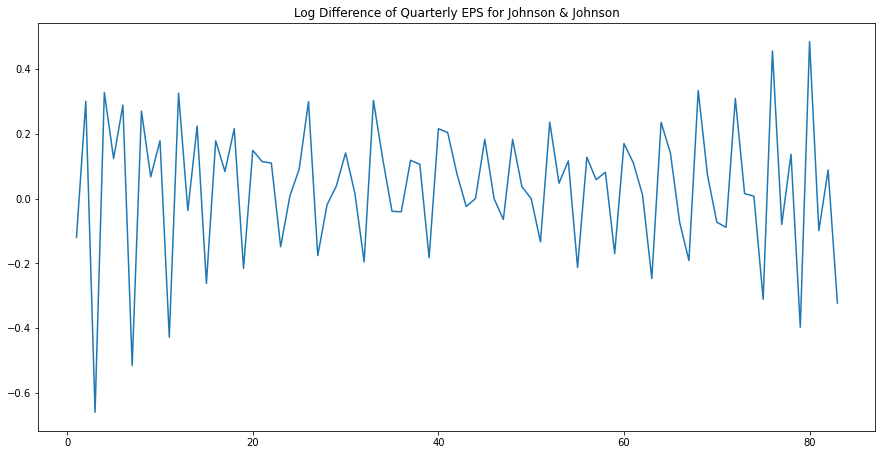

In [22]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [23]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


## Now the data is stationary, hence Augmented Regression can be used.

ADF Statistic: -4.317043945811837
p-value: 0.00041497314044406584


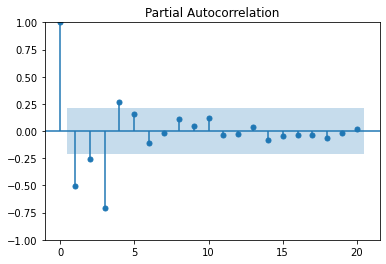

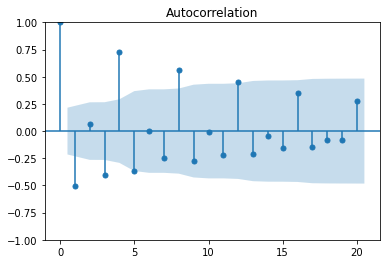

In [24]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [25]:
## We cannot decide the number of coefficients for AR and MA. So we would choose it based on AIC value

def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC

        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue

        aic = model.aic
        results.append([order, model.aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    print('hi')
    return result_df


In [26]:
from itertools import product
from tqdm import tqdm_notebook

from statsmodels.tsa.statespace.sarimax import SARIMAX


In [27]:
ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)
# Create a list with all possible combination of parameters

parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)

result_df = optimize_ARIMA(order_list, exog=data['data'])



/tmp/ipykernel_21706/2636322523.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):
Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


/home/archana/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/archana/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/archana/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/archana/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/archana/.local/lib/python3.10/site-pack

/home/archana/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/archana/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/archana/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/archana/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/archana/.local/lib/python3.10/s

/home/archana/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/archana/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/archana/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/archana/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/archana/.local/lib/python3.10/site-packa


hi


/home/archana/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [28]:
print(result_df)

    (p, d, q)         AIC
0   (3, 1, 3) -142.041665
1   (7, 1, 1) -141.634191
2   (7, 1, 5) -141.451368
3   (3, 1, 1) -140.470572
4   (3, 1, 4) -140.453181
..        ...         ...
59  (1, 1, 1)  -37.106446
60  (0, 1, 1)  -14.645882
61  (2, 1, 0)   14.952068
62  (1, 1, 0)   17.545808
63  (0, 1, 0)   68.249842

[64 rows x 2 columns]


In [29]:
best_model = SARIMAX(data['data'], order=(3,1,3)).fit()
print(best_model.summary())


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -9.15720D-01    |proj g|=  1.42500D+00

At iterate    5    f= -9.19804D-01    |proj g|=  2.80659D-01

At iterate   10    f= -9.24717D-01    |proj g|=  4.70337D-02

At iterate   15    f= -9.27058D-01    |proj g|=  5.53796D-01

At iterate   20    f= -9.31300D-01    |proj g|=  1.73169D-01

At iterate   25    f= -9.39015D-01    |proj g|=  7.54991D-02

At iterate   30    f= -9.39967D-01    |proj g|=  5.77615D-03

At iterate   35    f= -9.39971D-01    |proj g|=  4.70181D-03

At iterate   40    f= -9.40008D-01    |proj g|=  5.81020D-03

At iterate   45    f= -9.40010D-01    |proj g|=  1.78106D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [30]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [31]:
## Ideally, the residuals will be white noise, with no autocorrelation. A good way to test this is to use the Ljung-Box test.

ljung_box, p_value = acorr_ljungbox(best_model.resid)
print(f'Ljung-Box test: {ljung_box[:10]}')
print(f'p-value: {p_value[:10]}')


##Looking at the p-values above, we can see that they are above 0.05.
##Therefore, we cannot reject the null hypothesis, and the residuals are indeed not correlated

Ljung-Box test: lb_stat
p-value: lb_pvalue


General procedure that you can follow whenever you are faced with a time series:

1. Plot the data and identify unsual observations. Understand the pattern of the data.
2. Apply a transormation or differencing to remove the trend and stabilize the variance
3. Test for stationarity. If the series is not stationary, apply another transformation or differencing.
4. Plot the ACF and PACF to maybe estimate the order of the MA or AR process.
5. Try different combinations of orders and select the model with the lowest AIC.
6. Check the residuals and make sure that they look like white noise. Apply the Ljung-Box test to make sure.
7. Calculate forecasts




**Many to One Sentiment Analysis**

An RNN is a special type of neural network which works for sequential data. We can consider text as a sequential data of word tokens and process them using RNNS. RNNs can also be used for time series data but we will work on text.

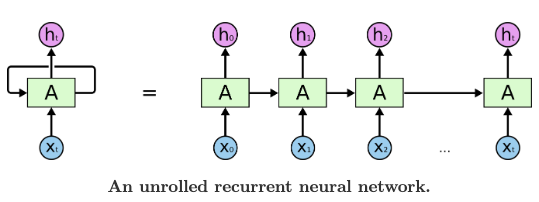

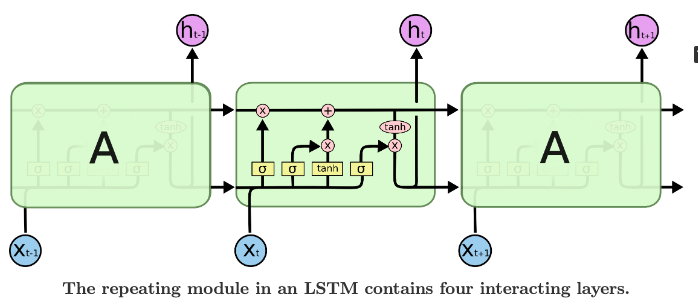

In [32]:
#Importing datasets
from keras.datasets import imdb

2023-10-10 15:42:09.741286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 15:42:10.574324: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [33]:
## Loading data from IMDB Dataset
vocabulary_size = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size)
print('Loaded dataset with {} training samples, {} test samples'.format(len(X_train), len(X_test)))


Loaded dataset with 25000 training samples, 25000 test samples


In [34]:
## Two dictionaries one from word to id and the other vice versa
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}

print([id2word.get(i, ' ') for i in X_train[6]])

print(y_train[6])


['the', 'and', 'full', 'involving', 'to', 'impressive', 'boring', 'this', 'as', 'and', 'and', 'br', 'villain', 'and', 'and', 'need', 'has', 'of', 'costumes', 'b', 'message', 'to', 'may', 'of', 'props', 'this', 'and', 'and', 'concept', 'issue', 'and', 'to', "god's", 'he', 'is', 'and', 'unfolds', 'movie', 'women', 'like', "isn't", 'surely', "i'm", 'and', 'to', 'toward', 'in', "here's", 'for', 'from', 'did', 'having', 'because', 'very', 'quality', 'it', 'is', 'and', 'and', 'really', 'book', 'is', 'both', 'too', 'worked', 'carl', 'of', 'and', 'br', 'of', 'reviewer', 'closer', 'figure', 'really', 'there', 'will', 'and', 'things', 'is', 'far', 'this', 'make', 'mistakes', 'and', 'was', "couldn't", 'of', 'few', 'br', 'of', 'you', 'to', "don't", 'female', 'than', 'place', 'she', 'to', 'was', 'between', 'that', 'nothing', 'and', 'movies', 'get', 'are', 'and', 'br', 'yes', 'female', 'just', 'its', 'because', 'many', 'br', 'of', 'overly', 'to', 'descent', 'people', 'time', 'very', 'bland']
1


In [35]:
#Pad sequences. To make all sequences length 500
from keras.preprocessing import sequence
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)


In [36]:
#Using LSTM RNN for classification task
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

## Embedding size is 32
embedding_size=32

## Model is sequential
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
#LSTM with 100 cells
model.add(LSTM(100))
## A dense layer to give output
model.add(Dense(1, activation='sigmoid'))
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213301 (833.21 KB)
Trainable params: 213301 (833.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [37]:
## Binary_Cross Entropy loss for binary classification task
## Adam optimzizer
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])


In [38]:
## Training the model in batches of 64 for 3 epochs
batch_size = 64
num_epochs = 3
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]
model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)

Epoch 1/3
390/390 [==============================] - 107s 269ms/step - loss: 0.4960 - accuracy: 0.7462 - val_loss: 0.2943 - val_accuracy: 0.8906
Epoch 2/3
390/390 [==============================] - 121s 311ms/step - loss: 0.3038 - accuracy: 0.8752 - val_loss: 0.2379 - val_accuracy: 0.8906
Epoch 3/3
390/390 [==============================] - 125s 321ms/step - loss: 0.2475 - accuracy: 0.9029 - val_loss: 0.2591 - val_accuracy: 0.8906


In [39]:
## Evaluating the task
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.8547999858856201


In [42]:
## Task is to use GRU instead of LSTM and report accuracy on IMDB dataset.
from keras.layers import GRU
## Embedding size is 32
embedding_size=32

## Model is sequential
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
#LSTM with 100 cells
model.add(GRU(100))
## A dense layer to give output
model.add(Dense(1, activation='sigmoid'))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 500, 32)           160000    
                                                                 
 gru (GRU)                   (None, 100)               40200     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 200301 (782.43 KB)
Trainable params: 200301 (782.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [43]:
## Binary_Cross Entropy loss for binary classification task
## Adam optimzizer
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [44]:
## Training the model in batches of 64 for 3 epochs
batch_size = 64
num_epochs = 3
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]
model.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)

Epoch 1/3
390/390 [==============================] - 96s 243ms/step - loss: 0.4530 - accuracy: 0.7746 - val_loss: 0.2239 - val_accuracy: 0.9375
Epoch 2/3
390/390 [==============================] - 95s 243ms/step - loss: 0.2807 - accuracy: 0.8868 - val_loss: 0.2232 - val_accuracy: 0.9375
Epoch 3/3
390/390 [==============================] - 95s 243ms/step - loss: 0.2311 - accuracy: 0.9107 - val_loss: 0.2025 - val_accuracy: 0.9062


In [45]:
## Evaluating the task
scores = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.8798800110816956


References

1) https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/#h2_1

2) https://colah.github.io/posts/2015-08-Understanding-LSTMs/

3) https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/

4) https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d

5)https://towardsdatascience.com/time-series-forecasting-with-autoregressive-processes-ba629717401

6) https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-to-time-series-analysis/#h2_1
